Setup complete. Using device: cuda

RUNNING ANALYSIS: MEMORY_BOTH_NODES_LATE


Generating tasks for memory_both_late: 100%|██████████| 250/250 [00:00<00:00, 8307.26it/s]


Evaluating SP-RW: 100%|██████████| 250/250 [00:05<00:00, 41.89it/s]
/tmp/ipykernel_10463/1797208287.py:168: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_model.index, y=accuracy_by_model.values, palette='viridis')


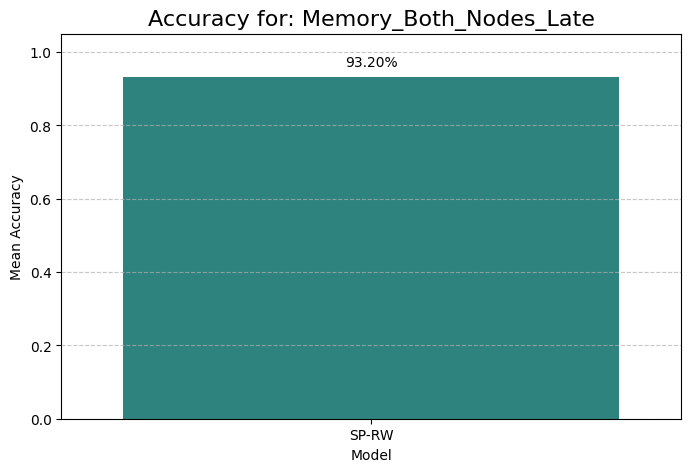


RUNNING ANALYSIS: MEMORY_START_EARLY_GOAL_LATE


Generating tasks for memory_start_early_goal_late: 100%|██████████| 250/250 [00:00<00:00, 10521.11it/s]
Evaluating SP-RW: 100%|██████████| 250/250 [00:07<00:00, 31.39it/s]
/tmp/ipykernel_10463/1797208287.py:168: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_model.index, y=accuracy_by_model.values, palette='viridis')


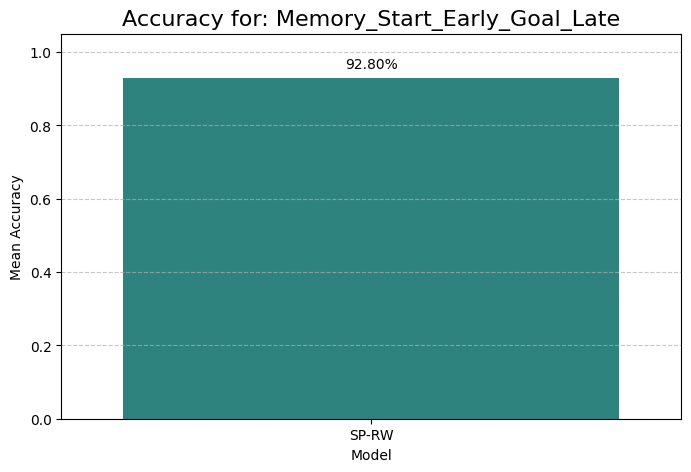


RUNNING ANALYSIS: MEMORY_CONSTRAINED_EXPANSION


Evaluating SP-RW: 100%|██████████| 250/250 [00:06<00:00, 40.46it/s]
/tmp/ipykernel_10463/1797208287.py:168: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_model.index, y=accuracy_by_model.values, palette='viridis')


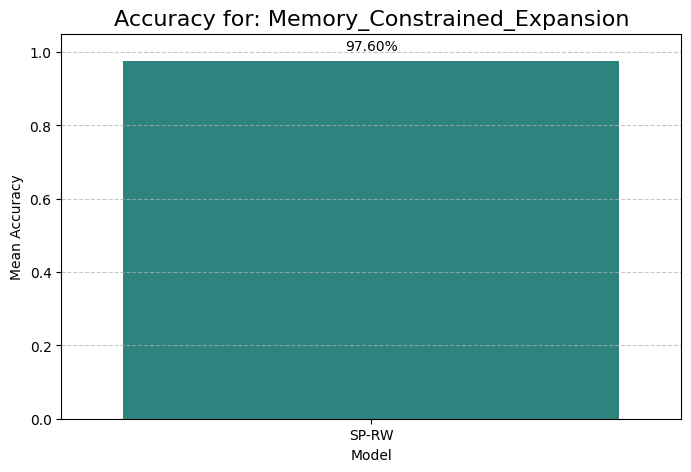



                         FINAL PERFORMANCE SUMMARY
| Model   |   Memory_Both_Nodes_Late |   Memory_Constrained_Expansion |   Memory_Start_Early_Goal_Late |
|:--------|-------------------------:|-------------------------------:|-------------------------------:|
| SP-RW   |                   93.20% |                         97.60% |                         92.80% |

Saved summary to 'memory_analysis_summary.json'
Saved detailed results to 'memory_analysis_detailed_results.csv'


In [2]:
# %%
# =============================================================================
# CELL 1: Setup and Configuration
# =============================================================================
import gc
import logging
import random
import string
import re
from abc import ABC, abstractmethod

import networkx as nx
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# --- General Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger("transformers").setLevel(logging.ERROR)

def set_seed(seed=42):
    """Sets the random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()
print(f"Setup complete. Using device: {DEVICE}")

# %%
# =============================================================================
# CELL 2: Core Classes and Essential Functions
# =============================================================================

class NavigationGPT:
    """A minimal wrapper for the GPT-2 model."""
    def __init__(self, model_path: str):
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model_path)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = GPT2LMHeadModel.from_pretrained(model_path, torch_dtype=torch.float32)
        self.model.config.pad_token_id = self.tokenizer.pad_token_id
        self.model.to(DEVICE)
        self.model.eval()

    def generate(self, prompt: str, max_new_tokens: int = 60):
        encodings = self.tokenizer(prompt, return_tensors='pt').to(DEVICE)
        with torch.no_grad():
            output_ids = self.model.generate(**encodings, max_new_tokens=max_new_tokens, num_beams=1)
        return self.tokenizer.decode(output_ids[0, encodings.input_ids.shape[1]:], skip_special_tokens=True).strip()

def generate_grid_graph(size=4):
    """Generates a grid graph with random 2-letter node names."""
    G = nx.DiGraph()
    num_nodes = size * size
    nodes = list(set([''.join(random.choices(string.ascii_lowercase, k=2)) for _ in range(num_nodes * 2)]))[:num_nodes]
    node_map = [['' for _ in range(size)] for _ in range(size)]
    for r in range(size):
        for c in range(size):
            idx = r * size + c
            node_map[r][c] = nodes[idx]
            if c < size - 1: G.add_edge(nodes[idx], nodes[idx + 1], direction='EAST')
            if c > 0: G.add_edge(nodes[idx], nodes[idx - 1], direction='WEST')
            if r < size - 1: G.add_edge(nodes[idx], nodes[idx + size], direction='SOUTH')
            if r > 0: G.add_edge(nodes[idx], nodes[idx - size], direction='NORTH')
    return G, nodes, node_map

def walk_to_string(walk, G):
    """Converts a path into the string format for the prompt."""
    if not walk or len(walk) < 2: return walk[0] if walk else ""
    return " ".join([f"{walk[i]} {G.edges[walk[i], walk[i+1]]['direction']}" for i in range(len(walk) - 1)] + [walk[-1]])

def create_test_cases(params):
    """Generates test cases specifically for the defined memory analyses."""
    test_cases = []
    task_type = params["task_type"]
    pbar = tqdm(total=params['num_tests'], desc=f"Generating tasks for {task_type}")
    attempts, max_attempts = 0, params['num_tests'] * 200

    while len(test_cases) < params['num_tests'] and attempts < max_attempts:
        attempts += 1
        G, _, node_map = generate_grid_graph(params['grid_size'])
        context, start_node, end_node = None, None, None

        if task_type in ['memory_both_late', 'memory_start_early_goal_late']:
            context = [random.choice(list(G.nodes()))]
            for _ in range(params['context_walk_length'] - 1):
                neighbors = list(G.successors(context[-1]))
                if not neighbors: break
                context.append(random.choice(neighbors))

            threshold = params['memory_threshold']
            early_nodes = set(context[:threshold])
            late_nodes = set(context) - early_nodes

            if task_type == 'memory_both_late':
                if len(late_nodes) < 2: continue
                start_node, end_node = random.sample(list(late_nodes), 2)
            else: # memory_start_early_goal_late
                if not early_nodes or not late_nodes: continue
                start_node = random.choice(list(early_nodes))
                end_node = random.choice(list(late_nodes))

        elif task_type == 'constrained_expansion_test':
            # Identify inner 3x3 and outer 4x4 nodes
            inner_nodes = {node_map[r][c] for r in range(3) for c in range(3)}
            outer_nodes = set(G.nodes()) - inner_nodes
            G_inner = G.subgraph(inner_nodes)

            # Generate the constrained walk
            path = [random.choice(list(G_inner.nodes()))]
            threshold = params['memory_threshold']
            
            # Part 1: Walk is constrained to the 3x3 grid
            for _ in range(threshold - 1):
                neighbors = list(G_inner.successors(path[-1]))
                if not neighbors: break
                path.append(random.choice(neighbors))
            if len(path) < threshold: continue # Walk failed to reach threshold length
            
            # Part 2: Walk expands to the full 4x4 grid
            for _ in range(params['context_walk_length'] - threshold):
                neighbors = list(G.successors(path[-1]))
                if not neighbors: break
                path.append(random.choice(neighbors))
            
            context = path
            # Select start/end nodes from outer nodes that were actually visited
            visited_outer_nodes = outer_nodes.intersection(set(context))
            if len(visited_outer_nodes) < 2: continue
            start_node, end_node = random.sample(list(visited_outer_nodes), 2)

        if not all([start_node, end_node, context, nx.has_path(G, start_node, end_node)]):
            continue

        test_cases.append({'graph': G, 'node_map': node_map, 'start': start_node, 'end': end_node, 'context': context})
        pbar.update(1)

    pbar.close()
    if len(test_cases) < params['num_tests']:
        logging.warning(f"Warning: Only generated {len(test_cases)}/{params['num_tests']} cases.")
    return test_cases

def score_and_analyze(parsed_nodes, task):
    """Scores a generated path and returns analysis metrics."""
    try:
        all_shortest_paths = list(nx.all_shortest_paths(task['graph'], task['start'], task['end']))
    except nx.NetworkXNoPath:
        all_shortest_paths = []

    is_valid = all(task['graph'].has_edge(parsed_nodes[i], parsed_nodes[i+1]) for i in range(len(parsed_nodes)-1))
    is_correct = is_valid and all_shortest_paths and parsed_nodes in all_shortest_paths
    return {'accuracy': 1.0 if is_correct else 0.0}

def plot_accuracy_results(df: pd.DataFrame, analysis_name: str):
    """Creates a simple bar plot for accuracy."""
    if df.empty: return
    plt.figure(figsize=(8, 5))
    accuracy_by_model = df.groupby('Model')['accuracy'].mean().sort_values()
    
    sns.barplot(x=accuracy_by_model.index, y=accuracy_by_model.values, palette='viridis')
    plt.title(f'Accuracy for: {analysis_name}', fontsize=16)
    plt.ylabel('Mean Accuracy')
    plt.xlabel('Model')
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Add accuracy values on top of bars
    for index, value in enumerate(accuracy_by_model):
        plt.text(index, value + 0.02, f'{value:.2%}', ha='center', va='bottom')
    plt.show()

# %%
# =============================================================================
# CELL 3: Experiment Definition and Configuration
# =============================================================================

class PromptStrategy(ABC):
    @abstractmethod
    def create_prompt(self, task: dict) -> str: pass

class StandardInstructionalStrategy(PromptStrategy):
    def create_prompt(self, task: dict) -> str:
        map_context_str = walk_to_string(task['context'], task['graph'])
        instruction = f"[SHORTEST] [START_NODE] {task['start']} [GOAL] {task['end']}"
        return f"[SOS] {map_context_str} [SEP] {instruction} [PLAN]"

MODELS_TO_ANALYZE = {
    "SP-RW": {
        "path": "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/sv3_model_ft/checkpoint-163000",
        "strategy": StandardInstructionalStrategy()
    }
}

ANALYSIS_PARAMS = {
    "Memory_Both_Nodes_Late": {
        "num_tests": 250, "grid_size": 4, "context_walk_length": 50,
        "memory_threshold": 29, "task_type": "memory_both_late"
    },
    "Memory_Start_Early_Goal_Late": {
        "num_tests": 250, "grid_size": 4, "context_walk_length": 50,
        "memory_threshold": 29, "task_type": "memory_start_early_goal_late"
    },
    "Memory_Constrained_Expansion": {
        "num_tests": 250, "grid_size": 4, "context_walk_length": 50,
        "memory_threshold": 29, "task_type": "constrained_expansion_test"
    }
}

# %%
# =============================================================================
# CELL 4: Main Execution Block
# =============================================================================

if __name__ == '__main__':
    all_results = []

    for analysis_name, params in ANALYSIS_PARAMS.items():
        print(f"\n{'='*80}\nRUNNING ANALYSIS: {analysis_name.upper()}\n{'='*80}")
        
        test_cases = create_test_cases(params)
        if not test_cases:
            logging.warning(f"Skipping '{analysis_name}' as no test cases could be generated.")
            continue
        
        # This script is designed for a single model, but the loop is kept for extensibility
        for model_name, config in MODELS_TO_ANALYZE.items():
            model = NavigationGPT(config['path'])
            
            # Run evaluation
            results_data = [score_and_analyze(re.findall(r'\b[a-z]{2}\b', model.generate(config['strategy'].create_prompt(task))), task)
                            for task in tqdm(test_cases, desc=f"Evaluating {model_name}")]
            
            # Format and store results
            results_df = pd.DataFrame(results_data)
            results_df['Model'] = model_name
            results_df['Analysis'] = analysis_name
            all_results.append(results_df)
            
            # Clean up GPU memory
            del model; gc.collect(); torch.cuda.empty_cache()

        # Plot results for the current analysis
        plot_accuracy_results(pd.concat(all_results, ignore_index=True).query(f"Analysis == '{analysis_name}'"), analysis_name)

    # --- Final Summary ---
    print("\n\n" + "="*80 + "\n" + " " * 25 + "FINAL PERFORMANCE SUMMARY" + "\n" + "="*80)
    if all_results:
        final_df = pd.concat(all_results, ignore_index=True)
        
        # Create and display pivot table
        summary_pivot = final_df.pivot_table(index='Model', columns='Analysis', values='accuracy')
        print(summary_pivot.to_markdown(floatfmt=".2%"))
        
        # Save results to files
        summary_pivot.to_json("memory_analysis_summary.json", orient='index', indent=4)
        final_df.to_csv("memory_analysis_detailed_results.csv", index=False)
        print("\nSaved summary to 'memory_analysis_summary.json'")
        print("Saved detailed results to 'memory_analysis_detailed_results.csv'")
    else:
        print("No analysis results were generated to summarize.")